# <center> CNN Forecasting </center>

In [110]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import ExponentialLR

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def create_sequences(serie, ventana):
    x = []
    y = []

    for i in range(len(serie)):
        idx = i+ventana
        if(idx >= len(serie)):
            break
        else:
            x.append(serie[i:(i+ventana)])
            y.append(serie[i+ventana])

    return torch.from_numpy(np.array(x)).float(), torch.from_numpy(np.array(y)).float()

In [25]:
def prepare_dataloaders(path):
    categoria = pd.read_csv(path, parse_dates=["fecha_hechos"])
    #categoria.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
    categoria.index = pd.DatetimeIndex(categoria.fecha_hechos)
    
    categoria_x_sem = categoria.resample("W", on = "fecha_hechos").size()
    ts_train_categoria=categoria_x_sem[categoria_x_sem.index<'2021-06']
    ts_valid_categoria= categoria_x_sem[categoria_x_sem[categoria_x_sem.index>='2021-06'] &
                                        categoria_x_sem[categoria_x_sem.index< "2022-06"]]
    ts_test_categoria = categoria_x_sem[categoria_x_sem.index>='2022-06']
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    sca_train_categoria = scaler.fit_transform(ts_train_categoria.values.reshape(-1, 1))
    sca_valid_categoria = scaler.transform(ts_valid_categoria.values.reshape(-1,1))
    sca_test_categoria = scaler.transform(ts_test_categoria.values.reshape(-1,1))
    
    X_train, y_train = create_sequences(sca_train_categoria.reshape(len(sca_train_categoria)), 3)
    X_val, y_val = create_sequences(sca_valid_categoria.reshape(len(sca_valid_categoria)), 3)
    X_test, y_test = create_sequences(sca_test_categoria.reshape(len(sca_test_categoria)), 3)
    
    batch_size = 1
    X_train_tensor = TensorDataset(X_train, y_train)
    X_train_dataloader = DataLoader(X_train_tensor, shuffle = False, batch_size=batch_size)
    X_train, y_train = [], []

    X_val_tensor = TensorDataset(X_val, y_val)
    X_val_dataloader = DataLoader(X_val_tensor, shuffle = False, batch_size=batch_size)
    X_val, y_val = [], []
    
    X_test_tensor = TensorDataset(X_test, y_test)
    X_test_dataloader = DataLoader(X_test_tensor, shuffle = False, batch_size=batch_size)
    X_test, y_test = [], []
    
    return X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler

In [4]:
class CNN1d(nn.Module):
    def __init__(self,
               dim_emb = 1,
               tam_filtros = [5, 4, 3, 2],
               num_filtros = [100, 100, 100, 100],
               salida_capas_FC = [],
               num_clases = 1,
               dropout = 0.5,
               activacion = 'relu'):
        
        super(CNN1d, self).__init__()
        # ==========================================================================
        # Preparación de embeddings
        self.dim_emb = dim_emb

        # ==========================================================================
        # Capa de convolución
        self.conv1d_list = nn.ModuleList([nn.Conv1d(in_channels  = self.dim_emb, 
                                                    out_channels = num_filtros[i], 
                                                    kernel_size = tam_filtros[i]) 
                                          for i in range(len(tam_filtros))])

        # ==========================================================================
        # Capa Fully-connected con BachNormalization y Dropout
        # self.fc = nn.Linear(np.sum(num_filtros),num_clases)

        self.BN_list = nn.ModuleList([nn.BatchNorm1d(nod) for nod in salida_capas_FC])

        if activacion == 'relu':
            self.activation = nn.ReLU()
        elif activacion == 'tanh':
            self.activation = nn.Tanh()

        SC_FC = salida_capas_FC
        SC_FC.insert(0,np.sum(num_filtros))
        SC_FC.append(num_clases)


        # Capa para preparar convolución
        self.fc_list = nn.ModuleList([nn.Linear(SC_FC[i], SC_FC[i+1]) for i in range(len(SC_FC)-1)])
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
          
        '''
           Estafunción realiza el paso fordward de la CNN
        '''    
        # Convoluciones y ReLu: #
        #x = x.float()
        x_conv_list = [F.relu(conv1d(x)) for conv1d in self.conv1d_list]

        # Max pooling
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[1]) for x_conv in x_conv_list]

        # Concatenamos Max pooling como input de Fully-connected
        x_fc = torch.cat([x_pool.squeeze(dim=1) for x_pool in x_pool_list], dim=0)

        # Fully-connected 
        n = len(self.BN_list)
        x_fc = self.fc_list[0](self.dropout(x_fc))
        
        for i in range(n):
            x_fc = self.activation(x_fc)
            x_fc = self.BN_list[i](x_fc)
            x_fc = self.fc_list[i+1](x_fc)

        return x_fc

In [5]:
def Starter_Model(dim_emb = 1,
                  tam_filtros = [5, 4, 3, 2],
                  num_filtros = [100, 100, 100, 100],
                  salida_capas_FC = [300,200,100],
                  num_clases = 1,
                  dropout = 0.5,
                  activacion = 'relu',
                  opt = 'Adadelta',
                  learning_rate = 0.01,
                  rho=0.95):
    
    """
    Esta función es un arrancador de una CNN considerando funciones de optimización ya implimentadas 
    en torch
    """
    # Condición que asegura que sea compatible
    if len(tam_filtros) != len(num_filtros):
        print("E: tam_filtros y num_filtros tiene que ser del mismo tamaño.")

    else:
        # Arranque de Modelo
        modelo = CNN1d(dim_emb = dim_emb,
                       tam_filtros = tam_filtros,
                       num_filtros = num_filtros,
                       salida_capas_FC = salida_capas_FC,
                       num_clases = num_clases,
                       dropout = dropout,
                       activacion = activacion)
        
        modelo.to(device)

        # Optimizadores
        if opt == 'Adam':
            opt = optim.Adam(modelo.parameters(), lr = learning_rate)
            
        elif opt == 'Adadelta':
            opt = optim.Adadelta(modelo.parameters(), lr = learning_rate, rho=rho)

    return modelo, opt

In [133]:
class RNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers,seq_len,num_classes):
        super().__init__()
        print("Esta es una RNN")
        self.num_layers = numLayers
        self.input_size = inputSize
        self.hidden_size = hiddenSize
        self.seq_len = seq_len
        self.RNN = nn.RNN(input_size=inputSize, 
                          hidden_size=hiddenSize, 
                          num_layers=numLayers, 
                          nonlinearity='tanh', 
                          batch_first=True)
        self.linear = nn.Linear(hiddenSize,num_classes)
        
    def forward(self,x):
        x=x.reshape([x.size(0),self.seq_len, 1]).float()
        hState = torch.zeros([self.num_layers, x.size(0), self.hidden_size])
        x, h = self.RNN(x,hState)
        out = self.linear(x[:,-1,:]) # gets last output
        return out

In [132]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers,seq_length, num_classes):
        super(LSTM, self).__init__()
        print("Esta es una LSTM")
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x=x.reshape([x.size(0),self.seq_len, 1]).float()
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [157]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, seq_length, dropout_prob):
        super(GRU, self).__init__()
        self.seq_length = seq_length
        self.num_layers = layer_dim
        self.hidden_size = hidden_dim
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x=x.reshape([x.size(0),self.seq_length, 1]).float()
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        _, h_out = self.gru(x, h_0)
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

In [158]:
def Starter_Model_Recurent(num_clases = 1,opt = 'Adadelta',learning_rate = 0.01,prob=0.25,
                  rho=0.95,device=device,seq_length=3,n_pred=1,red="rnn"):
  
    if red=='rnn': 
      modelo = RNN(num_clases,4,2,seq_length,n_pred)
    elif red=='lstm':
      modelo = LSTM(num_clases,4,2,seq_length,n_pred)
    else:
        modelo = GRU(num_clases,4,2,n_pred,3,prob)
    modelo.to(device)

    # Optimizadores
    if opt == 'Adam':
        opt = optim.Adam(modelo.parameters(), lr = learning_rate)
            
    elif opt == 'Adadelta':
        opt = optim.Adadelta(modelo.parameters(), lr = learning_rate, rho=rho)

    return modelo, opt

In [116]:
def train_step(model, loss_fn, train_loader, optimizer, device):
    losses = []
    model.train()
    
    for X, y in train_loader:
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        # Step 1 - Computes model's predicted output - forward pass
        model.zero_grad()
        yhat = model(X)
        #model.zero_grad()

        # Step 2 - Computes the loss
        loss = loss_fn(yhat.float(), y.float())

        # Acumulamos la función de pérdida
        losses.append(loss.item())

        # Step 3 - Computes gradients for both "b" and "w" parameters
        loss.backward()

        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
    return np.mean(losses)

In [117]:
def step_evaluation(model, loss_fn, val_loader, device):
    model.eval()
    with torch.no_grad():
        losses = []
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            
            yhat = model(X)
            
            # Step 2 - Computes the loss
            loss = loss_fn(yhat, y)

            # Total number of labels
            losses.append(loss.item())
            
    return np.mean(losses)

In [118]:
def MakePredictions(model, loader,device):
  with torch.no_grad():
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X = X.to(device)
        Y = Y.to(device)
        preds = model(X)
        Y_preds.append(preds.cpu().numpy()[0])
  
  return Y_preds

In [119]:
def all_in_one(model, loss_fn, optimizer, device, train_loader, val_loader, es, scheduler, epochs=10):
    train_losses = []
    val_losses =[]

    for i in range(1, epochs+1):
        
        error_train = train_step(model, loss_fn, train_loader, optimizer, device)
        error_val=step_evaluation(model, loss_fn, val_loader, device)
        
        train_losses.append(error_train)
        val_losses.append(error_val)
        
        scheduler.step()
        
        print(f'Epoch {i}', f'Train Loss: {error_train:.4f}', f'Test Loss: {error_val:.4f}',
              sep=' | ')        
        
        # Early Stopping
        if es(error_val, model):
            break
    
    return train_losses, val_losses

In [120]:
def EarlyStopping_plot(train_losses,test_losses):
    fig = plt.figure(figsize=(7,5))
    plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
    plt.plot(range(1,len(test_losses)+1), test_losses,label='Test Loss')
    plt.title("Gráfico Early Stopping")

    minposs = test_losses.index(min(test_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max(train_losses) + 0.5) # consistent scale
    plt.xlim(0, len(train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [121]:
class EarlyStopping:
    def __init__(self, mode, path, patience=3, delta=0):
        if mode not in {'min', 'max'}:
            raise ValueError("Argument mode must be one of 'min' or 'max'.")
        if patience <= 0:
            raise ValueError("Argument patience must be a postive integer.")
        if delta < 0:
            raise ValueError("Argument delta must not be a negative number.")
            
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.counter = 0
        
    def _is_improvement(self, val_score):
        """
        Return True iff val_score is better than self.best_score.
        """
        if self.mode == 'max' and val_score > self.best_score + self.delta:
            return True
        elif self.mode == 'min' and val_score < self.best_score - self.delta:
            return True
        return False
        
    def __call__(self, val_score, model):
        """
        Return True iff self.counter >= self.patience.
        """
        
        if self._is_improvement(val_score):
            self.best_score = val_score
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print('Test loss improved. Saved model.')
            return False
        else:
            self.counter += 1
            print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print(f'Stopped early. Best val loss: {self.best_score:.4f}')
                return True

In [122]:
#@title Definición de device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

## VIOLENCIA FAMILIAR

In [93]:
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders("/content/drive/My Drive/Proyecto_CD/Datos/violencia_familiar.csv")

In [162]:
# Step 0 - Initializes parameters "b" and "w" randomly
torch.manual_seed(69)

# Defines number of epochs
n_epochs = 100

#cnn, optimizer = Starter_Model(tam_filtros = [3,2],num_filtros = [100, 100],salida_capas_FC = [],num_clases = 1,learning_rate=0.25,
#                  dropout=0.35,activacion = 'relu', opt = 'Adadelta',rho=0.95)

network = "lstm"
dir_file = '/content/drive/My Drive/Proyecto_CD/'
neuronal_net, optimizer = Starter_Model_Recurent(num_clases = 1,learning_rate=0.25,device=device,seq_length=3,
                                                 n_pred=1, opt = 'Adadelta',rho=0.95,red=network)

# Inicializamos la condición de parada temprana
#es = EarlyStopping(mode='min', path='model_cnn_ST.pth', patience=10)
es = EarlyStopping(mode='min', path=dir_file+'model_'+str(network)+'_ST.pth', patience=10)

# Aplicamos un decaimiento a la tasa de aprendizaje de cada grupo de parámetros por gamma en cada época.
scheduler = ExponentialLR(optimizer, gamma=0.9)
loss_fn = nn.MSELoss()

train_losses, test_losses = all_in_one(neuronal_net, loss_fn, optimizer, device, X_train_dataloader, 
                                       X_val_dataloader, es, scheduler, n_epochs)

Esta es una LSTM


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Train Loss: 0.0580 | Test Loss: 0.0409
Test loss improved. Saved model.
Epoch 2 | Train Loss: 0.0742 | Test Loss: 0.0389
Test loss improved. Saved model.
Epoch 3 | Train Loss: 0.0446 | Test Loss: 0.0297
Test loss improved. Saved model.
Epoch 4 | Train Loss: 0.0240 | Test Loss: 0.0257
Test loss improved. Saved model.
Epoch 5 | Train Loss: 0.0189 | Test Loss: 0.0247
Test loss improved. Saved model.
Epoch 6 | Train Loss: 0.0181 | Test Loss: 0.0243
Test loss improved. Saved model.
Epoch 7 | Train Loss: 0.0179 | Test Loss: 0.0241
Test loss improved. Saved model.
Epoch 8 | Train Loss: 0.0178 | Test Loss: 0.0240
Test loss improved. Saved model.
Epoch 9 | Train Loss: 0.0176 | Test Loss: 0.0239
Test loss improved. Saved model.
Epoch 10 | Train Loss: 0.0175 | Test Loss: 0.0238
Test loss improved. Saved model.
Epoch 11 | Train Loss: 0.0175 | Test Loss: 0.0237
Test loss improved. Saved model.
Epoch 12 | Train Loss: 0.0174 | Test Loss: 0.0236
Test loss improved. Saved model.
Epoch 13 | Tr

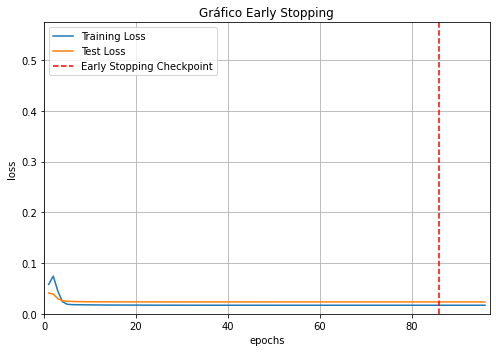

In [163]:
EarlyStopping_plot(train_losses,test_losses)

In [164]:
y_pred_scaler = MakePredictions(neuronal_net,X_train_dataloader,device)
y_pred = scaler.inverse_transform(np.array(y_pred_scaler).reshape(-1,1))
y_pred = y_pred.reshape(y_pred.shape[0])
fitted_series = pd.Series(y_pred)

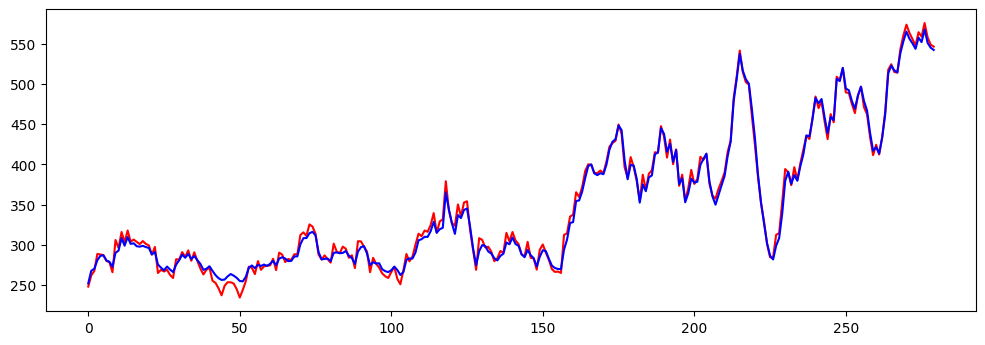

In [165]:
# Forecast
plt.figure(figsize=(12,4), dpi=100)
fitted_series.plot(color='red')
fitted_series_lstm.plot(color='blue')